In [2]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import spatial
from tqdm.auto import tqdm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jla7tqnx because the default path (/home/i313924/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [3]:
THREADS = 8

In [4]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/warp_model_1000_epochs_slim.pkl')

## Precision

In [6]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/lightfm_data/slim_interactions.npz')

In [ ]:
# Super time-consuming: https://github.com/lyst/lightfm/issues/510
precision_at_k(model, interactions, k=5, num_threads=THREADS).mean()

## ABX (only popular)

In [5]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset.pkl')

item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
items_embeddings = pd.DataFrame(model.item_embeddings)
items_embeddings = items_embeddings.rename(index=item_mapping)

In [6]:
abx_tests = pd.read_json('/pio/scratch/1/i313924/data/test_data/test_ABX_weighted_slim.json', lines=True)

In [7]:
A = np.zeros((10000, 100))
B = np.zeros((10000, 100))
X = np.zeros((10000, 100))

for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = items_embeddings.loc[test["A"]]
    B[i, :] = items_embeddings.loc[test["B"]]
    X[i, :] = items_embeddings.loc[test["X"]]

dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

print((dist_A < dist_B).mean())

cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)

for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

print((cos_dist_A < cos_dist_B).mean())

0it [00:00, ?it/s]

0.5278


  0%|          | 0/10000 [00:00<?, ?it/s]

0.5709


## Suits & dresses ABX

In [9]:
abx_tests_sd = pd.read_json('/pio/scratch/1/i313924/data/test_data/Suits_Dresses_ABX.json', lines=True)

A = np.zeros((10000, 100))
B = np.zeros((10000, 100))
X = np.zeros((10000, 100))

for i, test in tqdm(abx_tests_sd.iterrows()):
    A[i, :] = items_embeddings.loc[test["A"]]
    B[i, :] = items_embeddings.loc[test["B"]]
    X[i, :] = items_embeddings.loc[test["X"]]

dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

print((dist_A < dist_B).mean())

cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)

for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

print((cos_dist_A < cos_dist_B).mean())

0it [00:00, ?it/s]

0.5124


  0%|          | 0/10000 [00:00<?, ?it/s]

0.5321


## Embeddings PCA

In [10]:
user_embeddings = pd.DataFrame(model.user_embeddings)

In [12]:
embeddings = pd.concat([items_embeddings, user_embeddings], keys=['items', 'users'])

In [13]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [14]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

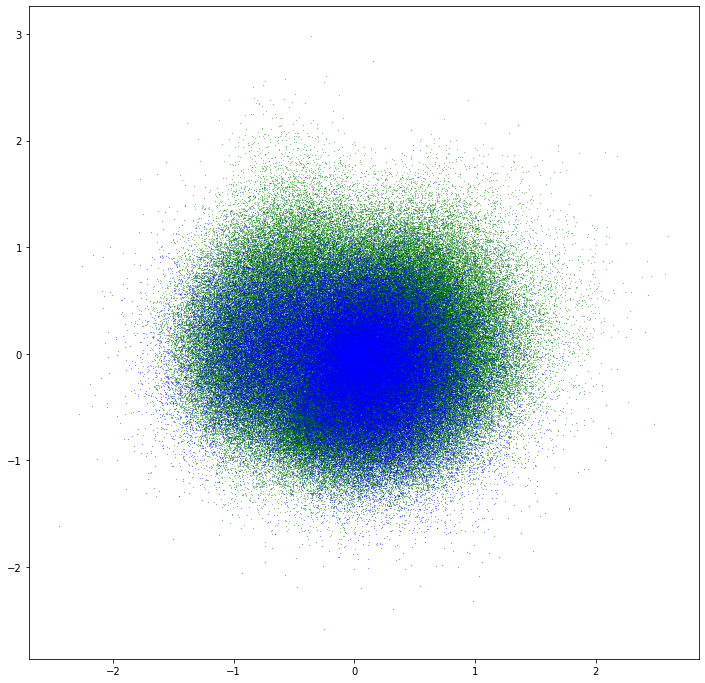

In [15]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [17]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [18]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [19]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [20]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [46]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


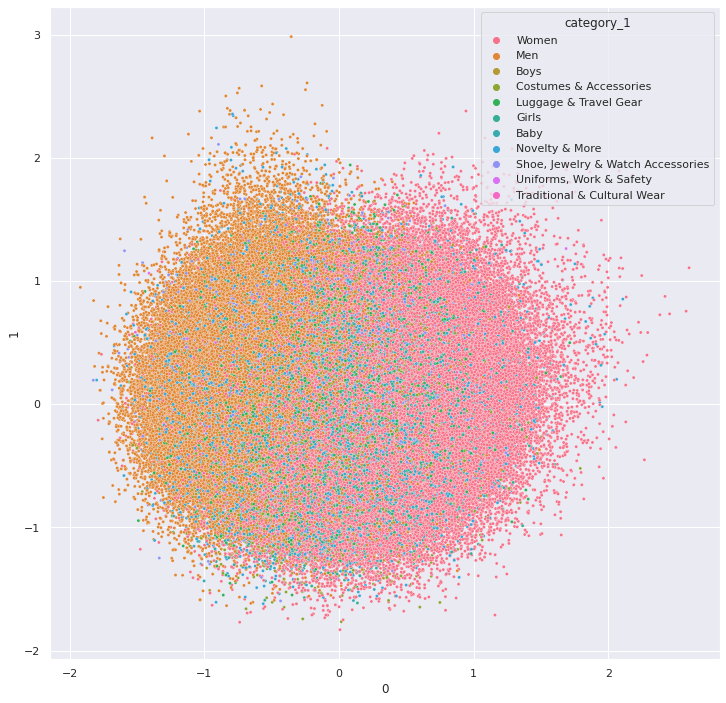

In [25]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

In [ ]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=tsne_reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

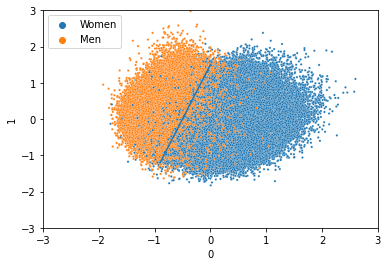

In [233]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
# y = 3x + 1.5
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

<AxesSubplot:xlabel='0', ylabel='1'>

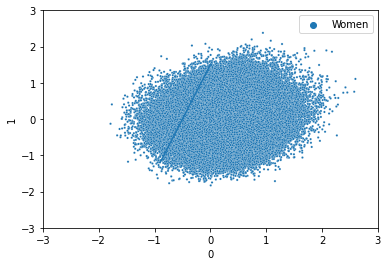

In [167]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

<AxesSubplot:xlabel='0', ylabel='1'>

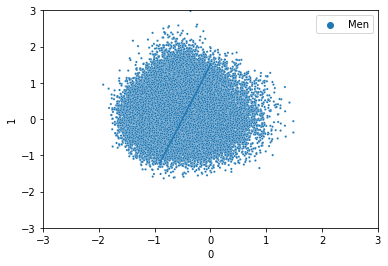

In [168]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin([ 'Men'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

In [153]:
women_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Women']
men_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Men']

In [155]:
left_women = women_embeddings[3*women_embeddings['0'] + 1.5 < women_embeddings['1']]
right_women = women_embeddings[3*women_embeddings['0'] + 1.5 > women_embeddings['1']]

In [156]:
left_men = men_embeddings[3*men_embeddings['0'] + 1.5 < men_embeddings['1']]
right_men = men_embeddings[3*men_embeddings['0'] + 1.5 > men_embeddings['1']]

In [162]:
len(left_women)/len(women_embeddings) * 100

5.625569166593226

In [163]:
len(right_men)/len(men_embeddings) * 100

34.33380574268575

0it [00:00, ?it/s]

[(-3.0, 3.0), (-3.0, 3.0)]

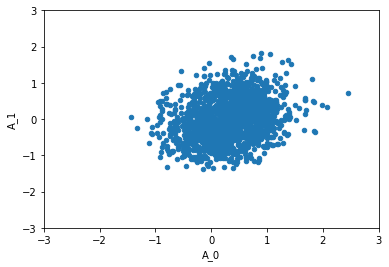

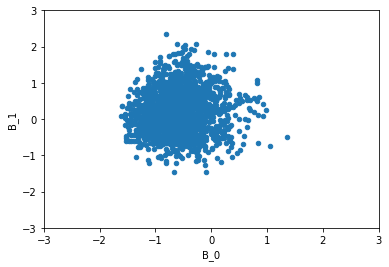

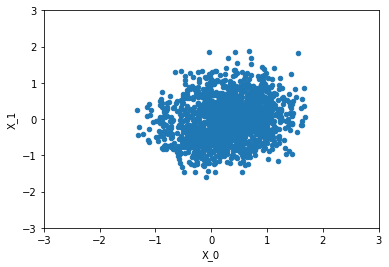

In [228]:
reduced_item_embeddings = reduced_item_embeddings.drop_duplicates()

l = []
for i, test in tqdm(abx_tests.iterrows()):
    if test["category_AX"] == "Women" and test["category_B"] == "Men":
        line = {
            "A_0":reduced_item_embeddings.loc[test["A"]]['0'],
            "A_1":reduced_item_embeddings.loc[test["A"]]['1'],
            "B_0":reduced_item_embeddings.loc[test["B"]]['0'],
            "B_1":reduced_item_embeddings.loc[test["B"]]['1'],
            "X_0": reduced_item_embeddings.loc[test["X"]]['0'],
            "X_1":reduced_item_embeddings.loc[test["X"]]['1'],

        }
        l.append(line)

scattered_abx = pd.DataFrame(l)

scattered_abx.plot.scatter(x="A_0", y="A_1").set(xlim = (-3,3), ylim=(-3, 3))
scattered_abx.plot.scatter(x="B_0", y="B_1").set(xlim = (-3,3), ylim=(-3, 3))
scattered_abx.plot.scatter(x="X_0", y="X_1").set(xlim = (-3,3), ylim=(-3, 3))

0it [00:00, ?it/s]

[(-3.0, 3.0), (-3.0, 3.0)]

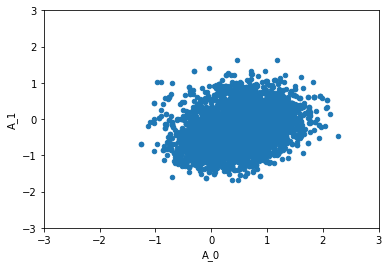

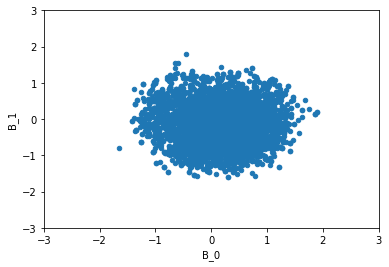

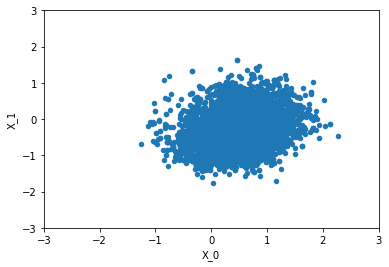

In [230]:
reduced_item_embeddings = reduced_item_embeddings.drop_duplicates()

l = []
for i, test in tqdm(abx_tests_sd.iterrows()):
    if test["category_AX"] == "Women" and test["category_B"] == "Men":
        line = {
            "A_0":reduced_item_embeddings.loc[test["A"]]['0'],
            "A_1":reduced_item_embeddings.loc[test["A"]]['1'],
            "B_0":reduced_item_embeddings.loc[test["B"]]['0'],
            "B_1":reduced_item_embeddings.loc[test["B"]]['1'],
            "X_0": reduced_item_embeddings.loc[test["X"]]['0'],
            "X_1":reduced_item_embeddings.loc[test["X"]]['1'],

        }
        l.append(line)

scattered_abx = pd.DataFrame(l)

scattered_abx.plot.scatter(x="A_0", y="A_1").set(xlim = (-3,3), ylim=(-3, 3))
scattered_abx.plot.scatter(x="B_0", y="B_1").set(xlim = (-3,3), ylim=(-3, 3))
scattered_abx.plot.scatter(x="X_0", y="X_1").set(xlim = (-3,3), ylim=(-3, 3))

## KNN

In [193]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)

In [194]:
samples = reduced_item_embeddings[['0', '1']].to_numpy()

In [195]:
neigh.fit(samples)

NearestNeighbors(n_neighbors=4)

In [203]:
women_nns = {}
for i in tqdm(range(len(women_embeddings))):
    women_nns[i] = reduced_item_embeddings.iloc[neigh.kneighbors(women_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]]['category_1'].values

  0%|          | 0/102123 [00:00<?, ?it/s]

In [211]:
women_not_nearest = 0
for _, v in women_nns.items():
    u, c = np.unique(v, return_counts=True)
    women_count = dict(zip(u, c)).get('Women')
    if women_count is None or women_count < 2:
        women_not_nearest += 1

In [216]:
women_not_nearest / len(women_embeddings) * 100

33.50665374107694

In [214]:
men_nearest = 0
for _, v in women_nns.items():
    u, c = np.unique(v, return_counts=True)
    men_count = dict(zip(u, c)).get('Men')
    if men_count is not None and men_count >= 2:
        men_nearest += 1

In [215]:
men_nearest / len(women_embeddings) * 100

7.458652801034048

In [224]:
men_embeddings[['0', '1']].to_numpy()[0, :]

array([-0.4553909,  0.5645828], dtype=float32)

In [226]:
neigh.kneighbors(men_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]

array([36292, 44086, 35924])

In [218]:
men_nns = {}
for i in tqdm(range(len(men_embeddings))):
    men_nns[i] = reduced_item_embeddings.iloc[neigh.kneighbors(men_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]]['category_1'].values

  0%|          | 0/51509 [00:00<?, ?it/s]

In [219]:
men_not_nearest = 0
for _, v in men_nns.items():
    u, c = np.unique(v, return_counts=True)
    men_count = dict(zip(u, c)).get('Men')
    if men_count is None or men_count < 2:
        men_not_nearest += 1

In [220]:
men_not_nearest / len(men_embeddings) * 100

42.837174086082044

In [221]:
women_nearest = 0
for _, v in men_nns.items():
    u, c = np.unique(v, return_counts=True)
    women_count = dict(zip(u, c)).get('Women')
    if women_count is not None and women_count >= 2:
        women_nearest += 1

In [222]:
women_nearest / len(men_embeddings) * 100

18.14246054087635